In [1]:
import os
import warnings
import datetime
import itertools

import numpy as np
import pandas as pd
import seaborn as sns

from github import Github
from matplotlib import pyplot, colors

warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

pyplot.rcParams['figure.figsize'] = [60/2.54, 36/2.54]

In [2]:
git = Github()
repo = git.get_repo('pr0nstar/covid19-data')

In [3]:
muni_data = pd.read_csv('../update/sdsn.gen.csv')
muni_data = muni_data.set_index('cod_ine')

In [4]:
def stylize_ax(ax, legend=True):
    if type(ax) == np.ndarray:
        [stylize_ax(_, legend) for _ in ax]
        return
    
    ax.grid(
        axis='both',
        which='both',
        color='DarkTurquoise', 
        alpha=0.2, 
        linestyle=':', 
        linewidth=2
    )
    
    if legend:
        ax.legend(loc='upper left')

### reportes diarios

In [5]:
paho_dir = repo.get_contents('raw/paho')
paho_dir_dict = {
    os.path.basename(_.path): _ for _ in paho_dir
}
paho_deaths_file = paho_dir_dict['deaths.timeline.csv']
paho_deaths_patch_file = paho_dir_dict['deaths.timeline.daily.patch.csv']

In [6]:
paho_df = pd.read_csv(paho_deaths_file.download_url, header=[0, 1], index_col=0)
paho_patch_df = pd.read_csv(paho_deaths_patch_file.download_url, header=[0, 1], index_col=0)

paho_df.update(paho_patch_df)
paho_df.index = pd.to_datetime(paho_df.index)

paho_df = paho_df['BOL'].dropna(how='all')

# Fix
paho_df = paho_df.drop_duplicates().asfreq('D')
paho_df = paho_df.interpolate('from_derivatives', limit_area='inside')

for _ in range(3):
    paho_df[(paho_df.diff() < 0).shift(-1).fillna(False)] = np.nan
    paho_df = paho_df.interpolate('from_derivatives', limit_area='inside')
    
for _ in range(3):
    paho_df[paho_df.diff() < 0] = np.nan
    paho_df = paho_df.interpolate('from_derivatives', limit_area='inside')

paho_df = paho_df.rename({
    'BO-B': 'beni',
    'BO-C': 'cochabamba',
    'BO-H': 'chuquisaca',
    'BO-L': 'la.paz',
    'BO-N': 'pando',
    'BO-O': 'oruro',
    'BO-P': 'potosi',
    'BO-S': 'santa.cruz',
    'BO-T': 'tarija'
}, axis=1)

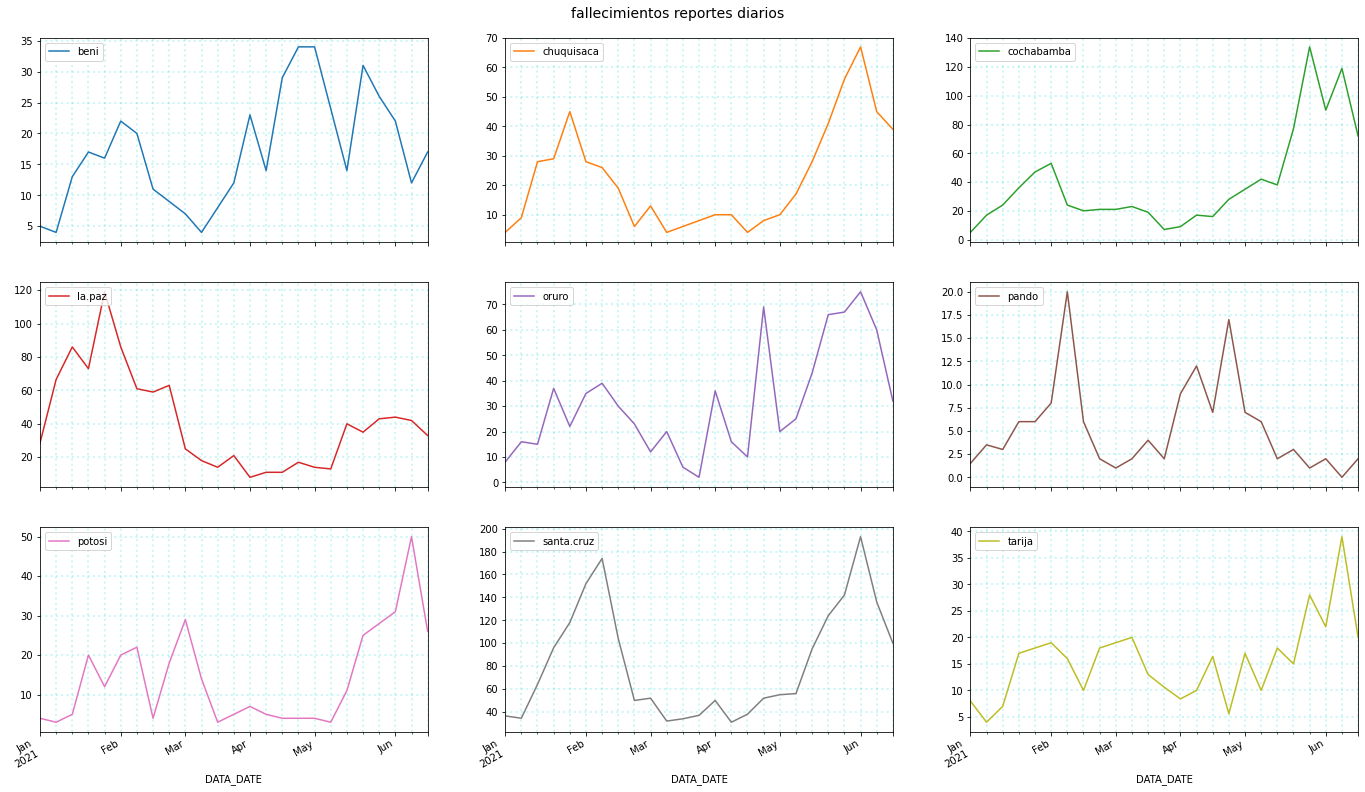

In [7]:
axs = paho_df[sorted(paho_df.columns)].diff().resample('W').sum().loc['2021':].plot(
    subplots=True, layout=(3, 3)
)

axs[0][1].get_figure().suptitle('fallecimientos reportes diarios', y=.91, fontsize=14)
stylize_ax(axs)

### siahv covid

In [8]:
def read_df(file_name):
    df = pd.read_csv(file_name, header=None)
    df.iloc[0] = pd.to_datetime(df.iloc[0])

    df.columns = pd.MultiIndex.from_frame(df.iloc[:3].T)
    df = df.iloc[3:]

    df.index = pd.MultiIndex.from_frame(df.iloc[:, :3])
    df.index.names = ['departamento', 'municipio', 'edad']
    df = df.iloc[:, 3:]

    df.columns = df.columns.droplevel(2)
    df = df.astype(int)
    
    return df

In [9]:
dept_paths = repo.get_contents('raw/bolivia/snis/siahv/covid')
dept_paths = [_ for _ in dept_paths if _.path.endswith('.csv')]

In [10]:
siahv_dept_data = {}

for file_name in dept_paths:
    df = read_df(file_name.download_url)
    df_name = os.path.basename(file_name.path).split('.')[0]
    df_name = pd.to_datetime(df_name)
    
    for dept_name in df.index.get_level_values(0).unique():
        dept_df = df.loc[dept_name].groupby(level=1).sum()
        dept_df = dept_df.groupby(level=0, axis=1).sum().sum()
        
        dept_df.name = df_name
        dept_df.index = pd.to_datetime(dept_df.index)
        
        siahv_dept_data[dept_name] = pd.concat([
            siahv_dept_data.get(dept_name, pd.DataFrame([])),
            dept_df
        ], axis=1)

In [11]:
for dept in siahv_dept_data.keys():
    siahv_dept = siahv_dept_data[dept]
    siahv_dept.index = pd.to_datetime(siahv_dept.index)
    siahv_dept_data[dept] = siahv_dept

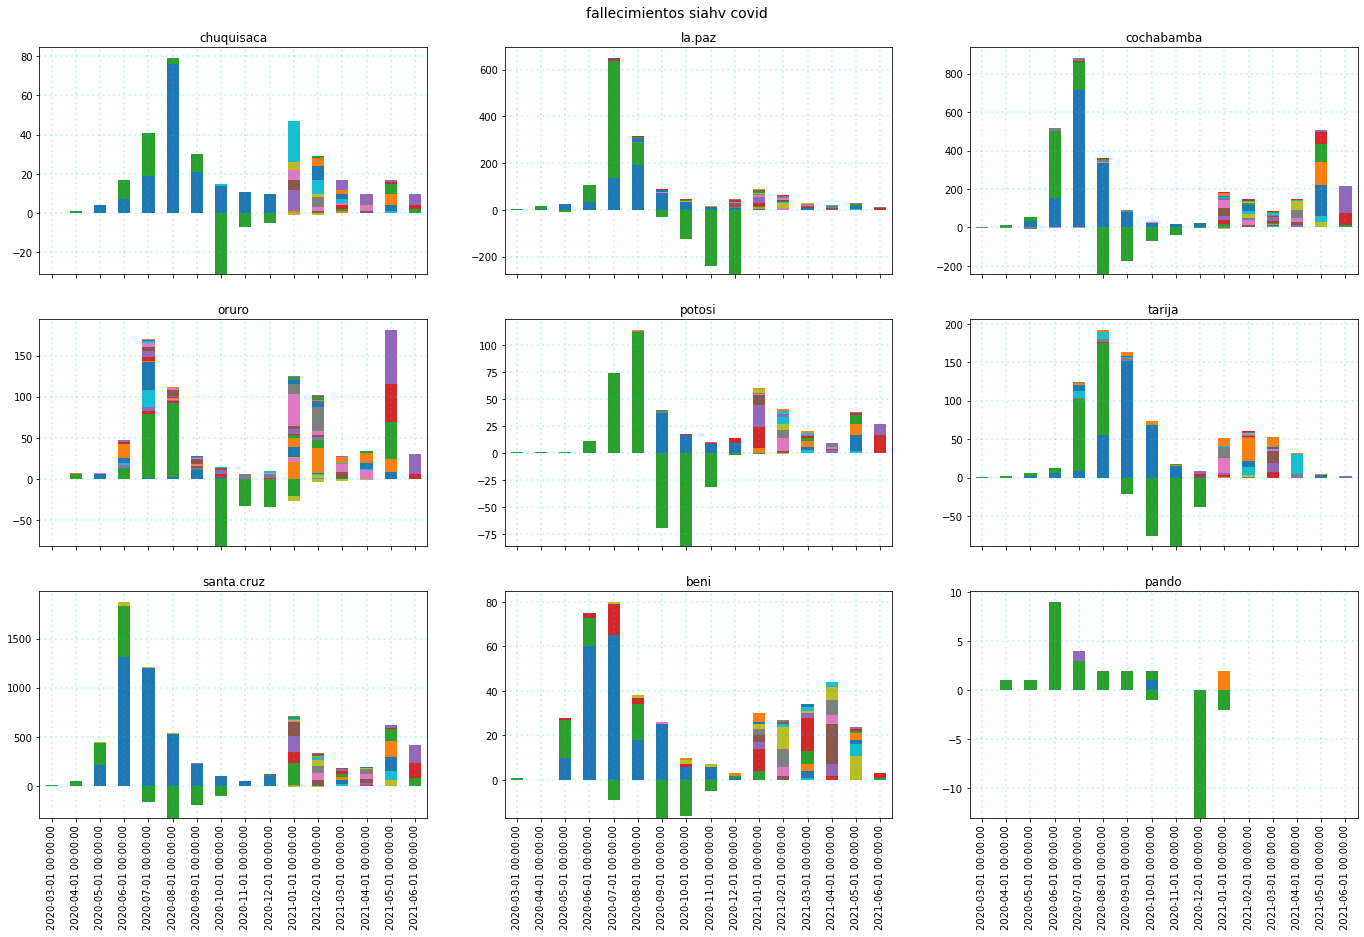

In [12]:
fig, axs = pyplot.subplots(ncols=3, nrows=3, sharex=True)
axs = axs.flatten()

for idx, dept in enumerate(siahv_dept_data.keys()):
    siahv_dept = siahv_dept_data[dept]
    siahv_dept = siahv_dept.T.fillna(0).diff().fillna(siahv_dept.T)
    
    siahv_dept.iloc[0] = siahv_dept.iloc[0] + siahv_dept[siahv_dept < -10].sum()
    siahv_dept = siahv_dept.resample('W').sum().T
    
    siahv_dept.plot(
        ax=axs[idx], kind='bar', stacked=True, legend=None
    )
    axs[idx].set_title(dept)
    
fig.suptitle('fallecimientos siahv covid', y=.92, fontsize=14)
stylize_ax(axs, legend=False)

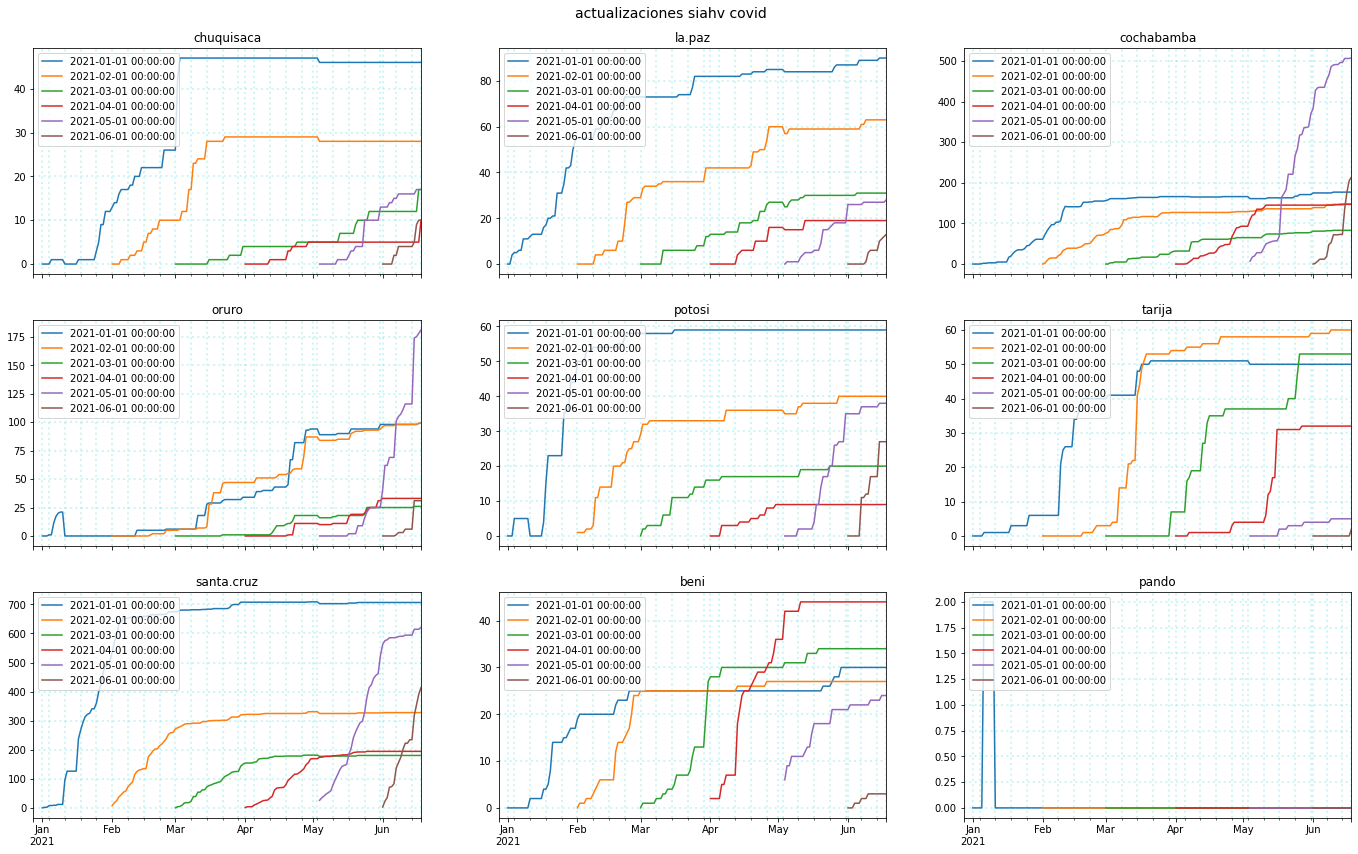

In [13]:
fig, axs = pyplot.subplots(ncols=3, nrows=3, sharex=True)
axs = axs.flatten()

for idx, dept in enumerate(siahv_dept_data.keys()):
    siahv_dept = siahv_dept_data[dept]
    
    siahv_dept.loc['2021-01-01':].T.plot(ax=axs[idx])
    axs[idx].set_title(dept)
    
fig.suptitle('actualizaciones siahv covid', y=.92, fontsize=14)
stylize_ax(axs)

In [14]:
siahv_dept_latest = read_df(dept_paths[-1].download_url)
siahv_dept_latest.groupby(level=0).sum().sum(axis=1)

departamento
beni           416
chuquisaca     324
cochabamba    3257
la.paz        1552
oruro          873
pando           20
potosi         479
santa.cruz    7084
tarija         806
dtype: int64

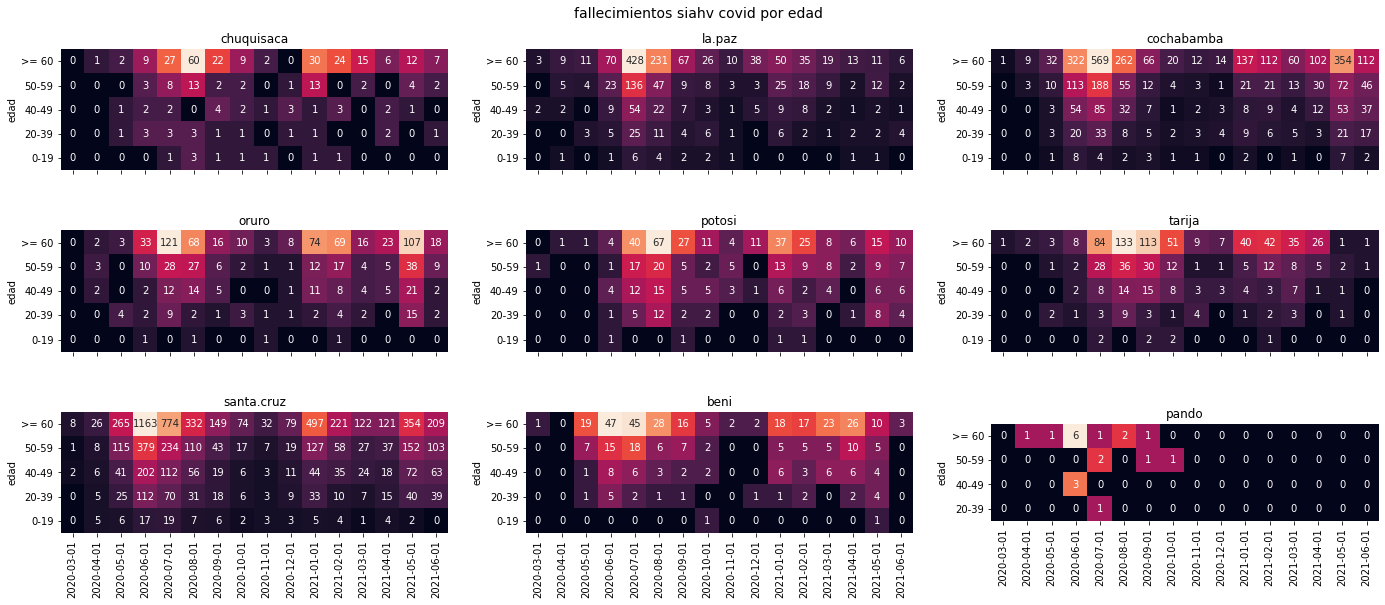

In [15]:
fig, axs = pyplot.subplots(ncols=3, nrows=3, figsize=(60/2.54, 24/2.54), sharex=True)
axs = axs.flatten()

for idx, dept in enumerate(siahv_dept_data.keys()):

    siahv_by_age = siahv_dept_latest.loc[dept].groupby(level=1).sum()
    siahv_by_age = siahv_by_age.groupby(level=0, axis=1).sum()
    
    siahv_by_age = siahv_by_age.loc[siahv_by_age.index[::-1]]
    siahv_by_age.columns = [str(_)[:10] for _ in siahv_by_age.columns]
    
    sns.heatmap(
        siahv_by_age,
        annot=True,
        fmt=".0f",
        square=True,
        norm=colors.PowerNorm(.5),
        cbar=False,
        ax=axs[idx],
    )
    axs[idx].set_title(dept)
    
_ = fig.suptitle('fallecimientos siahv covid por edad', y=.92, fontsize=14)

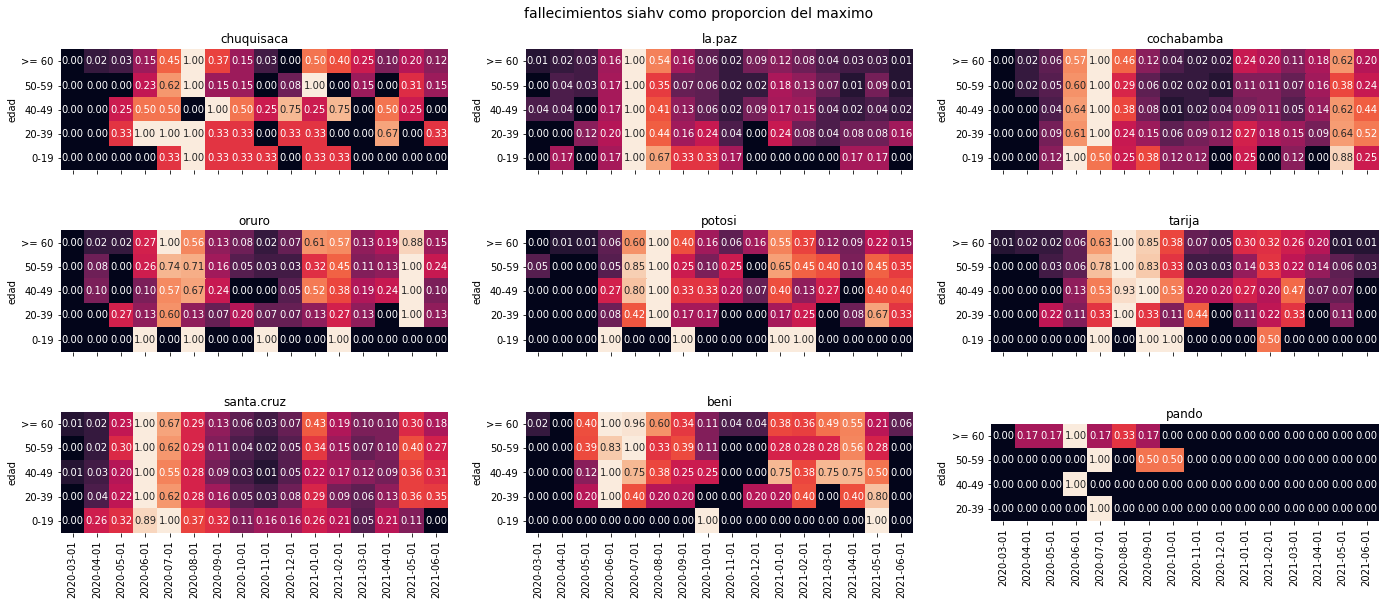

In [16]:
fig, axs = pyplot.subplots(ncols=3, nrows=3, figsize=(60/2.54, 24/2.54), sharex=True)
axs = axs.flatten()

for idx, dept in enumerate(siahv_dept_data.keys()):
    siahv_by_age = siahv_dept_latest.loc[dept].groupby(level=1).sum()
    siahv_by_age = siahv_by_age.groupby(level=0, axis=1).sum()
    
    siahv_by_age = siahv_by_age.T / siahv_by_age.max(axis=1)
    siahv_by_age = siahv_by_age.round(2).T
    
    siahv_by_age = siahv_by_age.loc[siahv_by_age.index[::-1]]
    siahv_by_age.columns = [str(_)[:10] for _ in siahv_by_age.columns]

    sns.heatmap(
        siahv_by_age,
        annot=True,
        fmt=".2f",
        square=True,
        norm=colors.PowerNorm(.5),
        cbar=False,
        ax=axs[idx],
    )
    axs[idx].set_title(dept)
    
_ = fig.suptitle('fallecimientos siahv como proporcion del maximo', y=.92, fontsize=14)

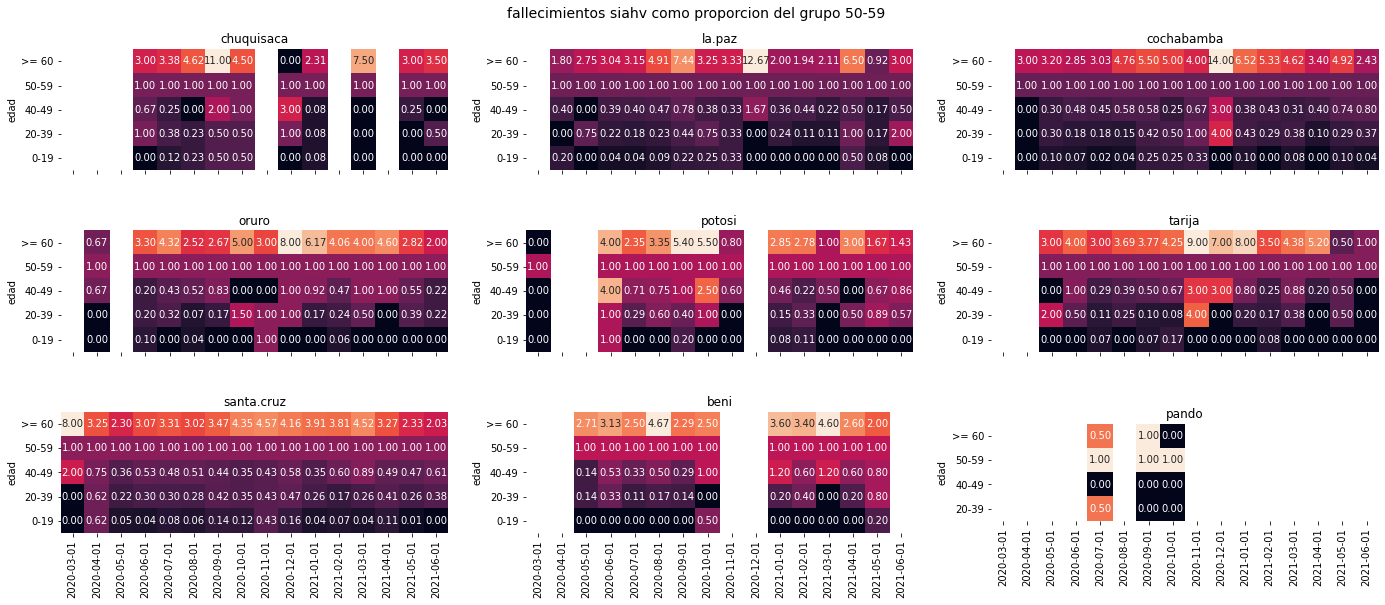

In [17]:
fig, axs = pyplot.subplots(ncols=3, nrows=3, figsize=(60/2.54, 24/2.54), sharex=True)
axs = axs.flatten()

for idx, dept in enumerate(siahv_dept_data.keys()):
    siahv_by_age = siahv_dept_latest.loc[dept].groupby(level=1).sum()
    siahv_by_age = siahv_by_age.groupby(level=0, axis=1).sum()
    
    siahv_by_age = siahv_by_age / siahv_by_age.loc['50-59']
    siahv_by_age = siahv_by_age.round(2)
    
    siahv_by_age = siahv_by_age.loc[siahv_by_age.index[::-1]]
    siahv_by_age.columns = [str(_)[:10] for _ in siahv_by_age.columns]

    sns.heatmap(
        siahv_by_age,
        annot=True,
        fmt=".2f",
        square=True,
        norm=colors.PowerNorm(.5),
        cbar=False,
        ax=axs[idx],
    )
    axs[idx].set_title(dept)
    
_ = fig.suptitle('fallecimientos siahv como proporcion del grupo 50-59 ', y=.92, fontsize=14)

### snis

In [18]:
AGE_MAP = {
    '0-19': ['a', 'b', 'c', 'd', 'e', 'f'],
    '20-39': ['g'],
    '40-49': ['h'],
    '50-59': ['i'],
    '>= 60': ['j']
}
CAT_AGE_MAP = dict(itertools.chain(*[
    itertools.product(v,(k,)) for k,v in AGE_MAP.items()
]))

def clean_df(df):
    data_df = df.loc[5:]
    data_df = data_df.loc[:, ~data_df.T.isna().T.all(axis=0)]
    data_df = data_df[~data_df.iloc[:, 2].isna()]

    data_df = data_df.iloc[:, 1:-2]
    data_df = data_df.T.reset_index(drop=True).T.reset_index(drop=True)

    data_df[0] = data_df[0].fillna(method='ffill')
    data_df = data_df.fillna(0)

    return data_df

def format_df(df):
    data_df = pd.DataFrame([])

    for muni, muni_df in df.groupby(0):
        muni_df = muni_df.set_index(1)
        fixed_df = pd.DataFrame([])

        for age, age_df in muni_df.groupby(lambda _: CAT_AGE_MAP[_[0]]):
            fixed_df[age] = age_df.iloc[:, 1:].sum(axis=0).reset_index(drop=True)

        fixed_df.columns = pd.MultiIndex.from_product([[muni], fixed_df.columns])
        data_df = pd.concat([data_df, fixed_df], axis=1)

    data_df.index = pd.MultiIndex.from_product([
        np.arange(len(data_df) / 2, dtype=int) + 1, ['Hombres', 'Mujeres']
    ])
    data_df = data_df.unstack()
    data_df.index = pd.to_datetime(
            data_df.index, unit='W', origin=pd.Timestamp('{}-01-01'.format(year))
    )

    return data_df

In [19]:
snis_dept_data = {}
year_paths = repo.get_contents('raw/bolivia/snis/estadisticas.reportes_dinamicos/mortalidad')

for year_dirname in year_paths:
    year = os.path.basename(year_dirname.path)
    
    dept_paths = repo.get_contents(year_dirname.path)
    dept_paths = [_ for _ in dept_paths if _.path.endswith('.xls') or _.path.endswith('.xlsx')]
    
    for file_name in dept_paths:
        dept_name = os.path.basename(file_name.path).rsplit('.', 1)[0]
        
        df = pd.read_excel(file_name.download_url, header=None)
        df = clean_df(df)
        df = format_df(df)
        
        dept_data = snis_dept_data.get(dept_name, {})
        dept_data[year] = df
        snis_dept_data[dept_name] = dept_data

WARNING *** file size (237270) not 512 + multiple of sector size (512)
WARNING *** file size (347851) not 512 + multiple of sector size (512)
WARNING *** file size (625792) not 512 + multiple of sector size (512)
WARNING *** file size (1028007) not 512 + multiple of sector size (512)
WARNING *** file size (222375) not 512 + multiple of sector size (512)
WARNING *** file size (98163) not 512 + multiple of sector size (512)
WARNING *** file size (403291) not 512 + multiple of sector size (512)
WARNING *** file size (727013) not 512 + multiple of sector size (512)
WARNING *** file size (143367) not 512 + multiple of sector size (512)
WARNING *** file size (78976) not 512 + multiple of sector size (512)
WARNING *** file size (125974) not 512 + multiple of sector size (512)
WARNING *** file size (222343) not 512 + multiple of sector size (512)
WARNING *** file size (362031) not 512 + multiple of sector size (512)
WARNING *** file size (74659) not 512 + multiple of sector size (512)
WARNING 

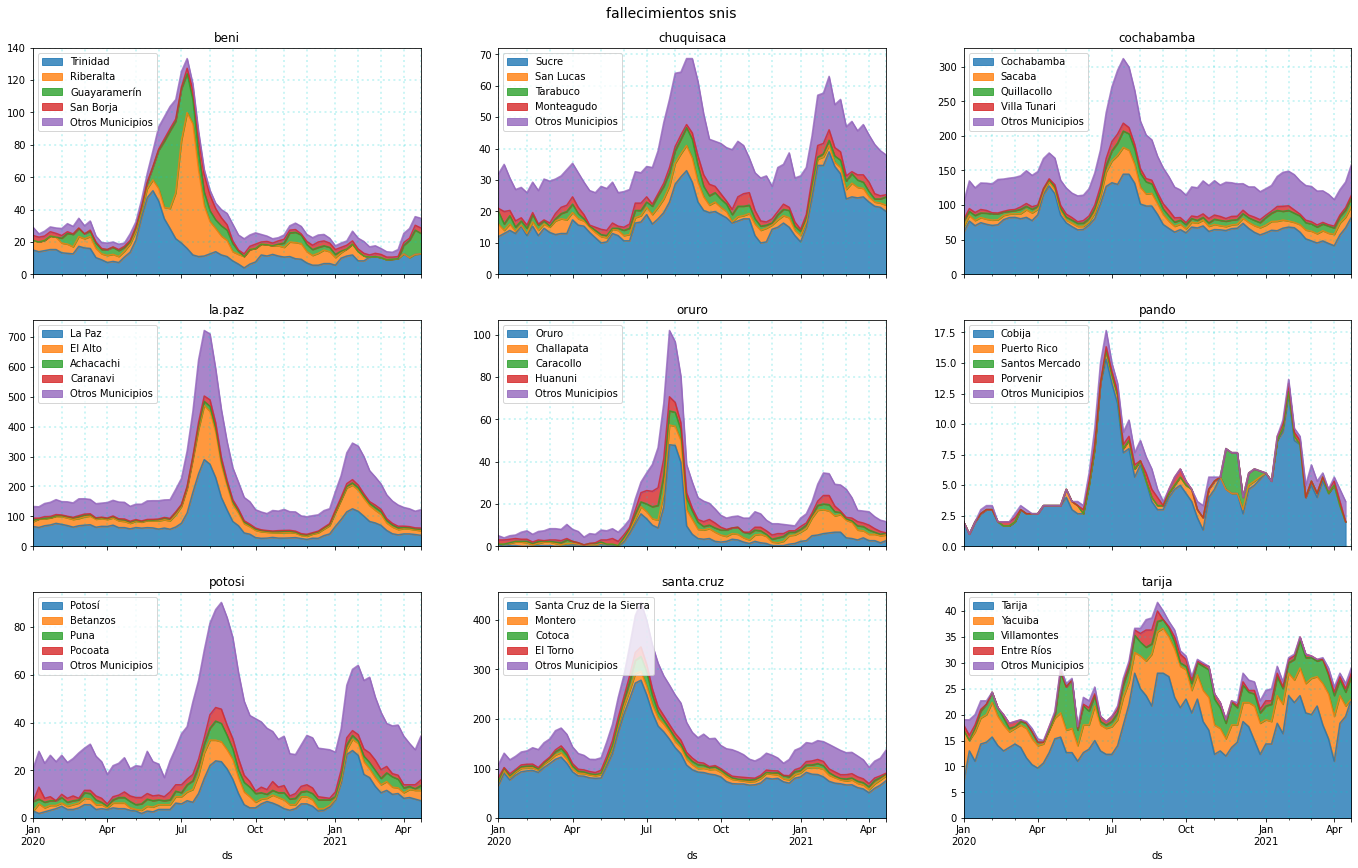

In [20]:
fig, axs = pyplot.subplots(ncols=3, nrows=3, sharex=True)
axs = axs.flatten()

for idx, dept in enumerate(snis_dept_data.keys()):
    dept_df = snis_dept_data[dept]
    dept_df = pd.concat(dept_df.values()).sort_index()
    dept_df.index = dept_df.index.rename('ds')

    dept_df = dept_df.T.groupby(level=0).sum().T.copy()
    dept_df.columns = dept_df.columns.astype(np.int64)
    
    dept_df = dept_df.loc['2020':]
    dept_df = dept_df.iloc[:-1]
    idx_df = dept_df.sum().sort_values(ascending=False)
    
    dept_plot_df = dept_df[idx_df[:4].index].copy()
    dept_plot_df = dept_plot_df.rename(columns=muni_data['municipio'])
    if len(idx_df) > 4:
        rest_df = dept_df[idx_df[4:].index].sum(axis=1)
        dept_plot_df['Otros Municipios'] = rest_df
        
    dept_plot_df.rolling(window=3).mean().fillna(dept_plot_df).plot(
        title=dept, kind='area', alpha=.8, ax=axs[idx]
    )

_ = fig.suptitle('fallecimientos snis', y=.92, fontsize=14)
stylize_ax(axs)

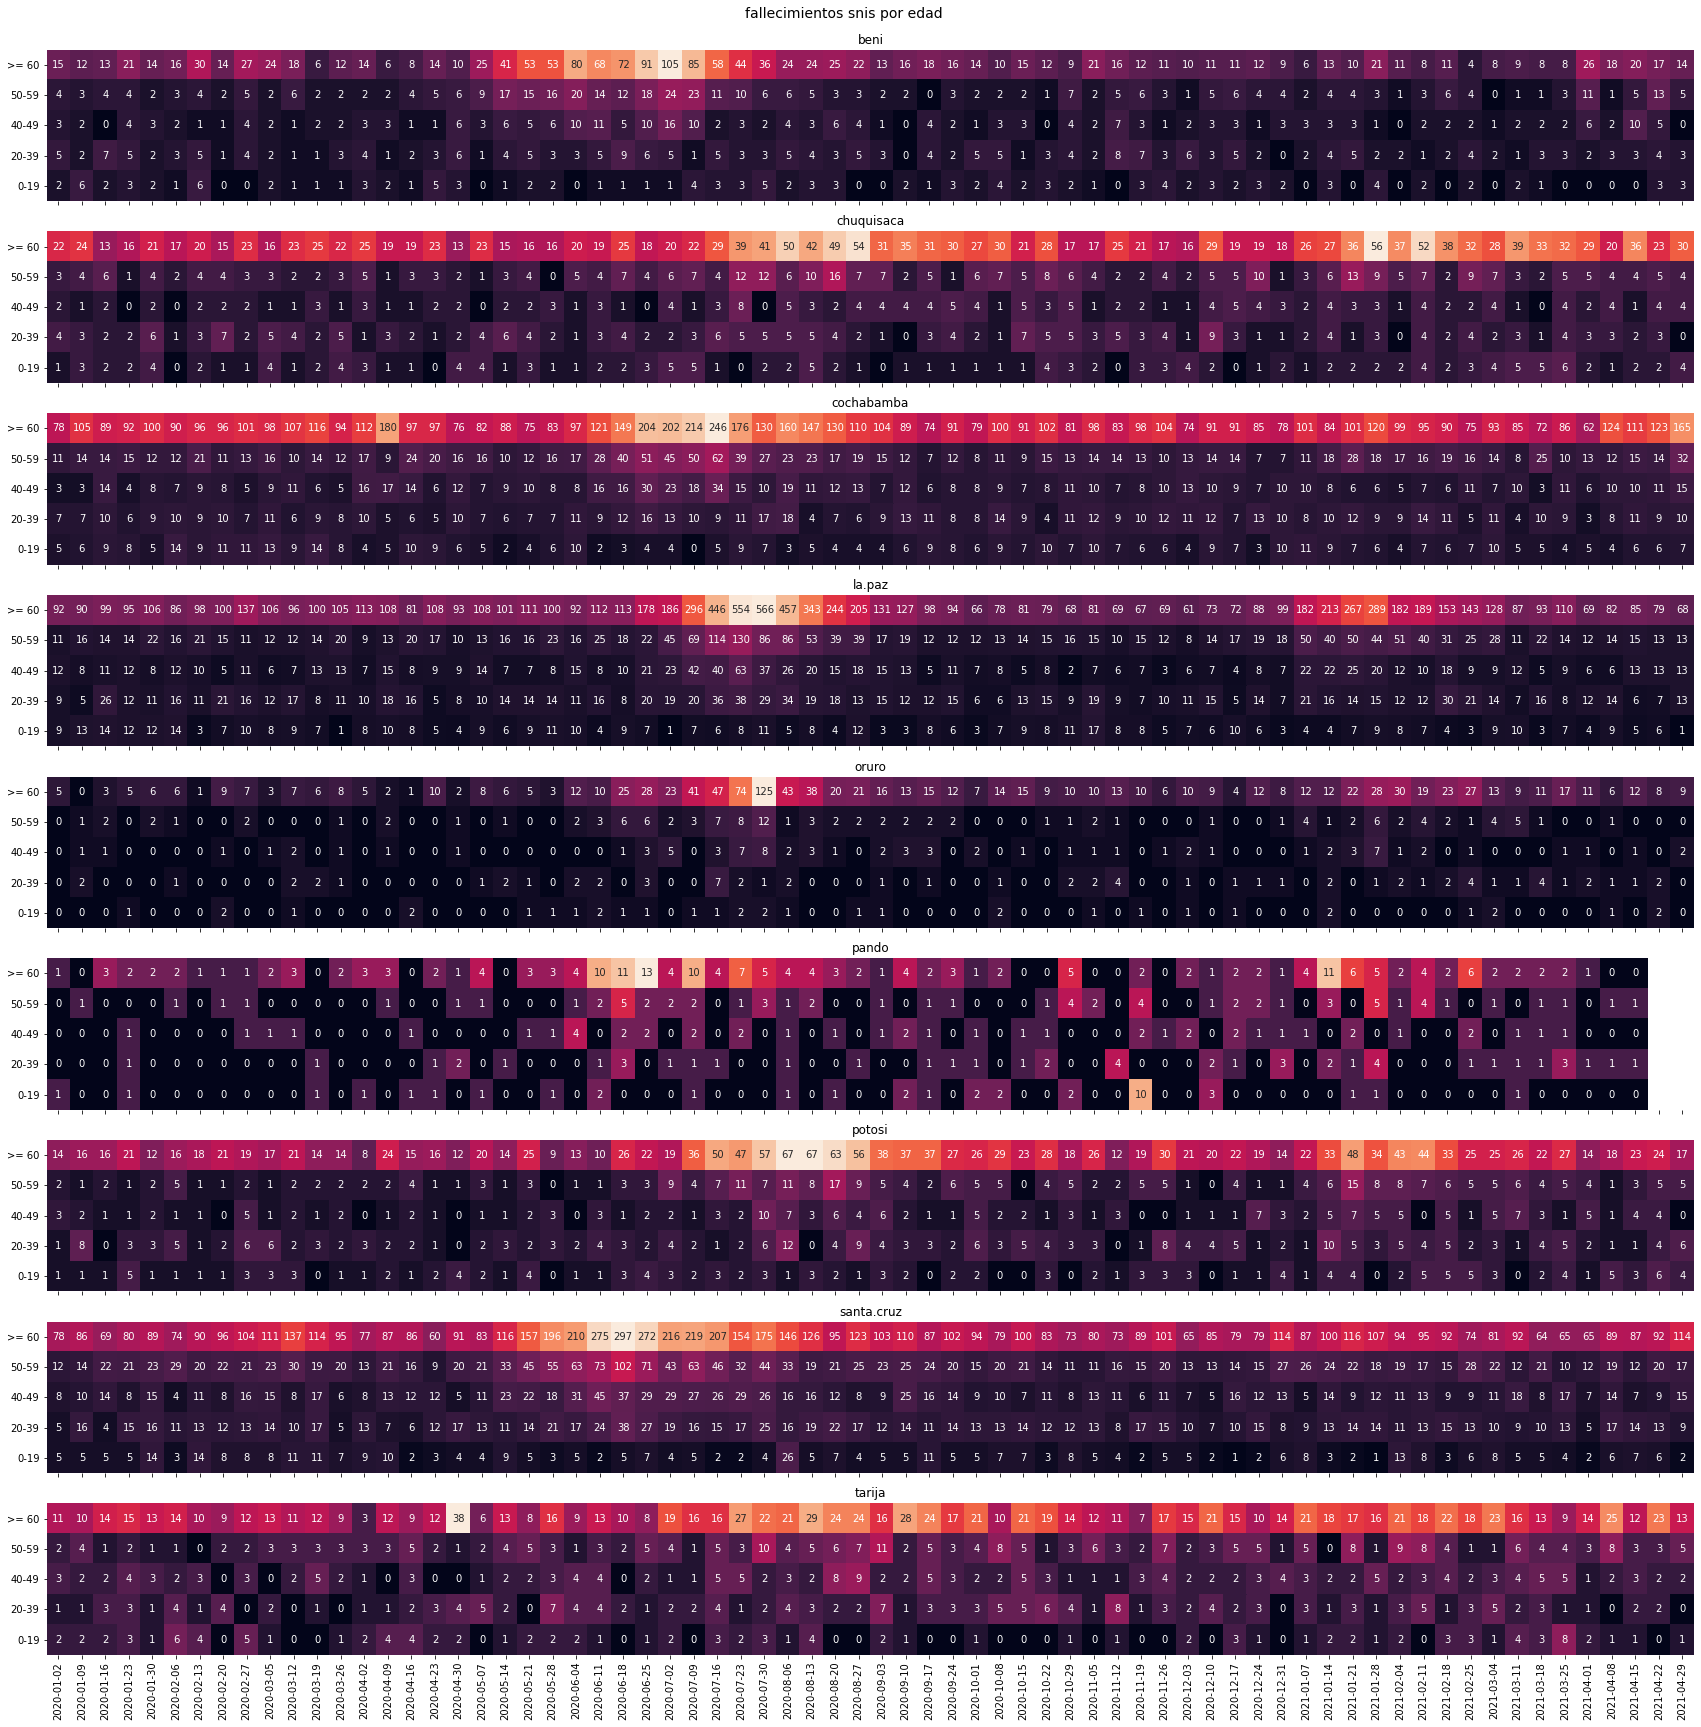

In [21]:
fig, axs = pyplot.subplots(figsize=(75/2.54, 75/2.54), ncols=1, nrows=9, sharex=True)

for idx, dept in enumerate(snis_dept_data.keys()):
    dept_df = snis_dept_data[dept]
    dept_df = pd.concat([dept_df['2020'], dept_df['2021']]).sort_index()
    dept_df.index = dept_df.index.rename('ds')
    
    by_age = dept_df.groupby(level=1, axis=1).sum().T
    by_age = by_age.loc[by_age.index[::-1]]
    by_age.columns = [str(_)[:10] for _ in by_age.columns]

    sns.heatmap(
        by_age,
        annot=True,
        fmt=".0f",
        norm=colors.PowerNorm(.66),
        ax=axs[idx],
        cbar=False
    )
    axs[idx].set_title(dept)
    
_ = fig.suptitle('fallecimientos snis por edad', y=.9, fontsize=14)

### sereci

In [22]:
sereci_dir = repo.get_contents('raw/bolivia/sereci')
sereci_file = {
    os.path.basename(_.path): _ for _ in sereci_dir
}['sereci.by.death.date.csv']

In [23]:
sereci_df = pd.read_csv(sereci_file.download_url, index_col=0)
sereci_df.index = pd.to_datetime(sereci_df.index)

sereci_df.columns = [_.lower().replace(' ', '.') for _ in sereci_df.columns]
sereci_df = sereci_df[sorted(sereci_df.columns)]

sereci_df.tail(5)

,beni,chuquisaca,cochabamba,la.paz,oruro,pando,potosi,santa.cruz,tarija
2021-01-01,234,334,1029,4372,495,48,543,1787,284
2021-02-01,200,290,952,2643,452,33,476,1391,296
2021-03-01,267,319,1007,1835,393,39,435,1309,361
2021-04-01,298,259,1025,1513,304,60,338,1265,261
2021-05-01,257,397,2006,2041,648,33,466,2144,345


In [24]:
def resample_monthly(df, method='from_derivatives', **kwargs):
    df = df.copy()
    
    df_index = df.index[0]
    df.index = df.index + pd.DateOffset(months=1, days=-1)
    df.loc[df_index - pd.DateOffset(days=2)] = 0
    df = df.sort_index()

    df = df.cumsum().asfreq('d')
    df = df.interpolate(method, **kwargs)
    
    df = df.diff().dropna().resample('W').sum()
    df = df.round()
    
    return df

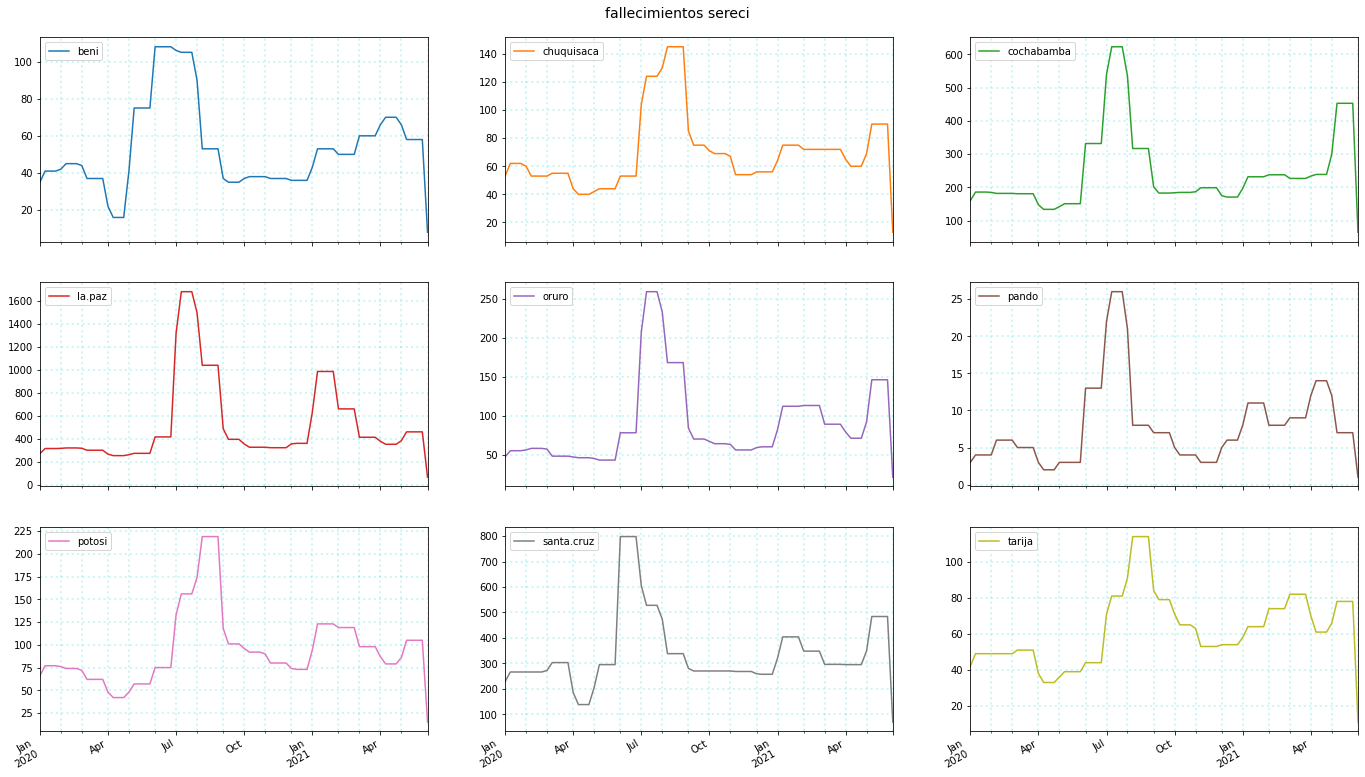

In [25]:
axs = resample_monthly(sereci_df['2020':]).plot(
    subplots=True, layout=(3, 3)#, color='red', alpha=.75
)

# axs = resample_monthly(sereci_df['2020':], method='pchip').plot(
#     subplots=True, ax=axs.flatten(), color='green', alpha=.9
# )

axs[0][0].get_figure().suptitle('fallecimientos sereci', y=.91, fontsize=14)
stylize_ax(axs)

### Comparativo

In [26]:
snis_dept_total = pd.DataFrame([])

for dept in snis_dept_data.keys():
    t_dept_df = pd.concat(
        snis_dept_data[dept].values()
    ).sort_index().sum(axis=1)
    t_dept_df = t_dept_df.rename(dept)
    
    snis_dept_total = pd.concat([snis_dept_total, t_dept_df], axis=1)
    
snis_dept_total.index = pd.to_datetime(snis_dept_total.index)
snis_dept_total.index = snis_dept_total.index - pd.Timedelta(days=4)

snis_dept_total = snis_dept_total.resample('M').sum()
snis_dept_total.index = snis_dept_total.index - pd.offsets.MonthBegin(1)


In [27]:
snis_dept_total_base = snis_dept_total[:'2020-03-31']
snis_dept_total_base = snis_dept_total_base.set_index(
    snis_dept_total_base.index.month, append=True
).groupby(level=1).mean()
snis_dept_total_base = snis_dept_total_base.round()

In [28]:
snis_dept_base = pd.DataFrame([])

for year in range(2020, 2021 + 1):
    t_snis_df = snis_dept_total_base.copy()
    t_snis_df.index = [
        datetime.datetime(year, _, 1) for _ in snis_dept_total_base.index
    ]
    
    snis_dept_base = pd.concat([
        snis_dept_base, t_snis_df
    ])

In [29]:
def stylize_comparison(axs, loc='upper right'):
    for idx, ax in enumerate(axs):
        ax.set_title(sorted(paho_df.columns)[idx])
        ax.legend(
            ax.get_lines(), 
            ['snis', 'sereci', 'siahv covid', 'reportes diarios'], 
            loc=loc
        )
        ax.grid(
            axis='both',
            which='both',
            color='DarkTurquoise', 
            alpha=0.2, 
            linestyle=':', 
            linewidth=2
        )

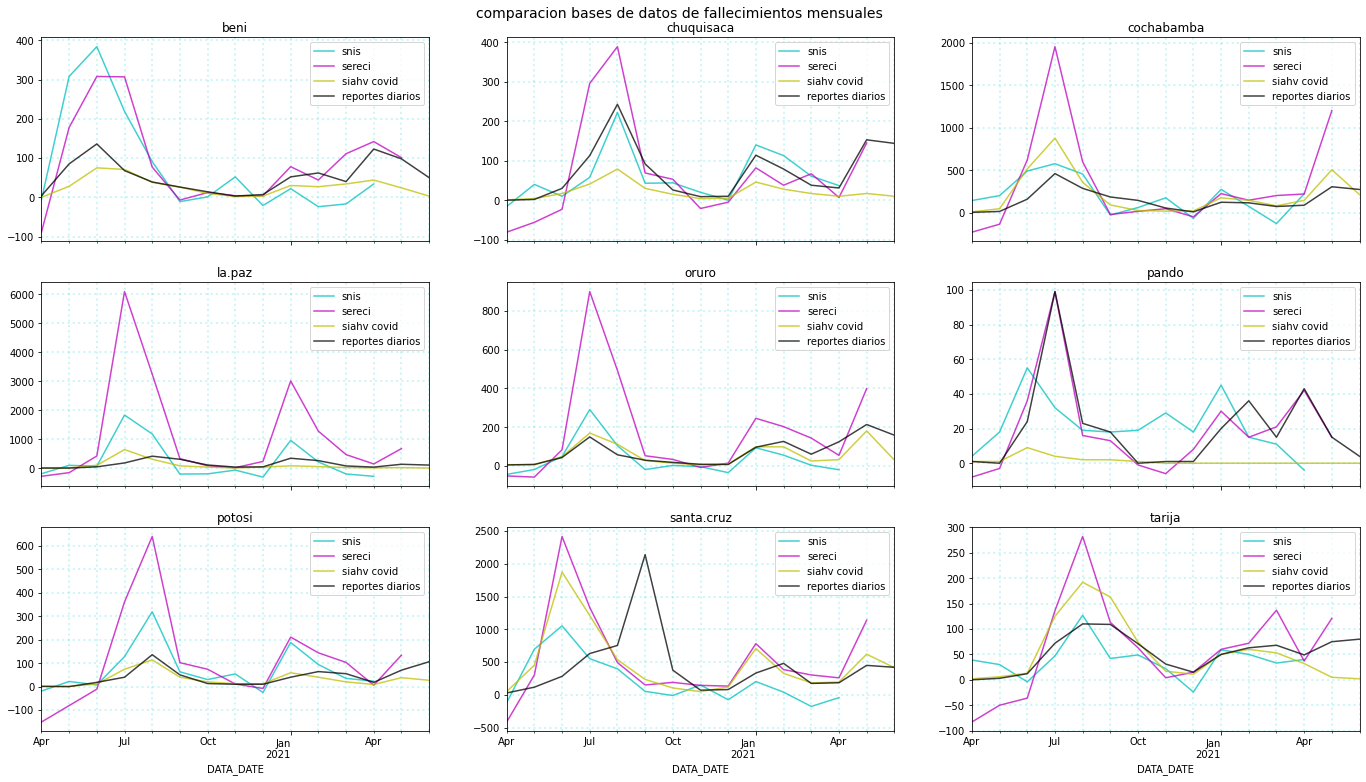

In [30]:
snis_dept_total_plot = snis_dept_total['2020-04-01':] - snis_dept_base
snis_dept_total_plot = snis_dept_total_plot.dropna(how='all')[sorted(paho_df.columns)]
axs = snis_dept_total_plot.plot(
    subplots=True, layout=(3, 3), color='c', alpha=.75
)
axs = axs.flatten()

sereci_df_plot = sereci_df['2020-04-01':] - sereci_df[:'2019'].mean().round()
sereci_df_plot = sereci_df_plot[sorted(paho_df.columns)]
axs = sereci_df_plot.plot(
    subplots=True, ax=axs, color='m', alpha=.75
)

siahv_dept_plot = siahv_dept_latest.groupby(level=0).sum()
siahv_dept_plot = siahv_dept_plot.groupby(level=0, axis=1).sum()
siahv_dept_plot = siahv_dept_plot.T[sorted(paho_df.columns)].loc['2020-04-01':]
axs = siahv_dept_plot.plot(
    subplots=True, ax=axs, color='y', alpha=.75
)


paho_df_plot = paho_df[sorted(paho_df.columns)].diff().resample('M').sum()
paho_df_plot.index = paho_df_plot.index - pd.offsets.MonthBegin(1)
paho_df_plot = paho_df_plot.loc['2020-04':]

axs = paho_df_plot.plot(
    subplots=True, ax=axs, color='k', alpha=.75
)

axs[0].get_figure().suptitle(
    'comparacion bases de datos de fallecimientos mensuales', y=.91, fontsize=14
)
stylize_comparison(axs)

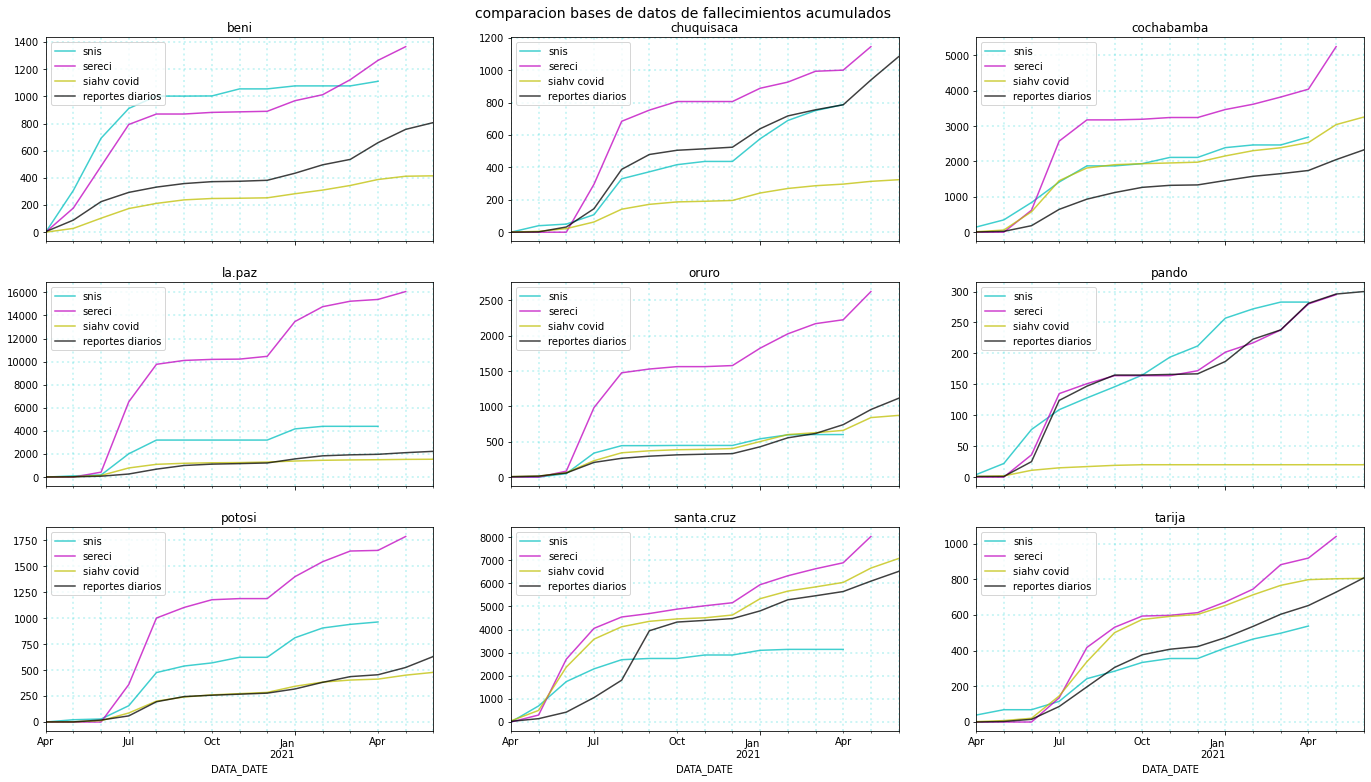

In [31]:
def do_cumsum(df):
    df = df.copy()
    df[df < 0] = 0
    
    return df.cumsum()

axs = do_cumsum(snis_dept_total_plot).plot(
    subplots=True, layout=(3, 3), color='c', alpha=.75
)
axs = axs.flatten()

axs = do_cumsum(sereci_df_plot).plot(
    subplots=True, ax=axs, color='m', alpha=.75
)

axs = do_cumsum(siahv_dept_plot).plot(
    subplots=True, ax=axs, color='y', alpha=.75
)

axs = do_cumsum(paho_df_plot).plot(
    subplots=True, ax=axs, color='k', alpha=.75
)

axs[0].get_figure().suptitle(
    'comparacion bases de datos de fallecimientos acumulados', y=.91, fontsize=14
)
stylize_comparison(axs, loc='upper left')

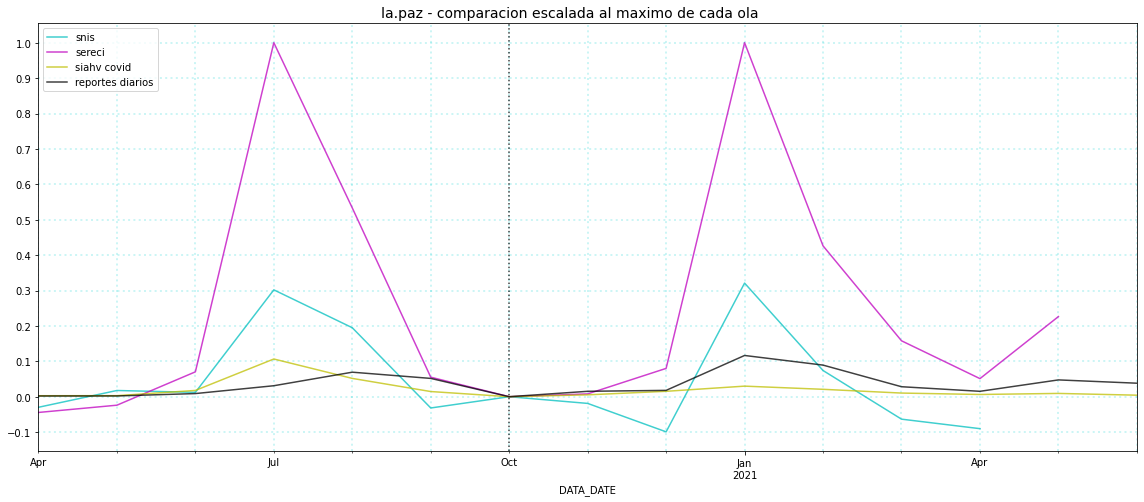

In [32]:
dept = 'la.paz'

def scale_df(df):
    df = df.copy()
    
    df[:'2020-10-01'] = df[:'2020-10-01'] / sereci_df_plot[:'2020-10-01'].max()
    df['2020-10-01':] = df['2020-10-01':] / sereci_df_plot['2020-10-01':].max()
    
    return df

axs = scale_df(snis_dept_total_plot)[dept].plot(
    color='c', alpha=.75, figsize=(50/2.54, 20/2.54)
)

axs = scale_df(sereci_df_plot)[dept].plot(
    ax=axs, color='m', alpha=.75
)

axs = scale_df(siahv_dept_plot)[dept].plot(
    ax=axs, color='y', alpha=.75
)

axs = scale_df(paho_df_plot)[dept].plot(
    ax=axs, color='k', alpha=.75
)

axs.get_figure().suptitle(
    '{} - comparacion escalada al maximo de cada ola'.format(dept), y=.91, fontsize=14
)
axs.legend(
    axs.get_lines(), 
    ['snis', 'sereci', 'siahv covid', 'reportes diarios'], 
    loc='upper left'
)
axs.grid(
    axis='both',
    which='both',
    color='DarkTurquoise', 
    alpha=0.2, 
    linestyle=':', 
    linewidth=2
)
axs.axvline('2020-10-01', linestyle=':', color='black', alpha=.75)
_ = axs.set_yticks(np.arange(-.1, 1.01, .1))